##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Object Detection


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/object_detection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/object_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=google%2Ffaster_rcnn%2Fopenimages_v4%2Finception_resnet_v2%2F1%20OR%20google%2Ffaster_rcnn%2Fopenimages_v4%2Finception_resnet_v2%2F1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This Colab demonstrates use of a TF-Hub module trained to perform object detection.

## Setup


In [2]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
import cv2
# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import pandas as pd
# For measuring the inference time.
import time
import os
import pandas
from shapely.geometry import Polygon

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.7.0
The following GPU devices are available: 


2022-05-18 21:12:54.399122: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Example use

### Helper functions for downloading images and for visualization.

Visualization code adapted from [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) for the simplest required functionality.

In [3]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, box, class_name, score, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    ymin, xmin, ymax, xmax = box
    display_str = "{}: {}%".format(class_name.decode("ascii"),
                                     int(100 * score))
    color = "#ff0000"
    image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
    draw_bounding_box_on_image(
        image_pil,
        ymin,
        xmin,
        ymax,
        xmax,
        color,
        font,
        display_str_list=[display_str])
    np.copyto(image, np.array(image_pil))
    return image

## Apply module

Load a public image from Open Images v4, save locally, and display.

Image downloaded to /var/folders/1q/d65s3kns3w9cq7jtvnwgb27m0000gn/T/tmp11ogm8ku.jpg.


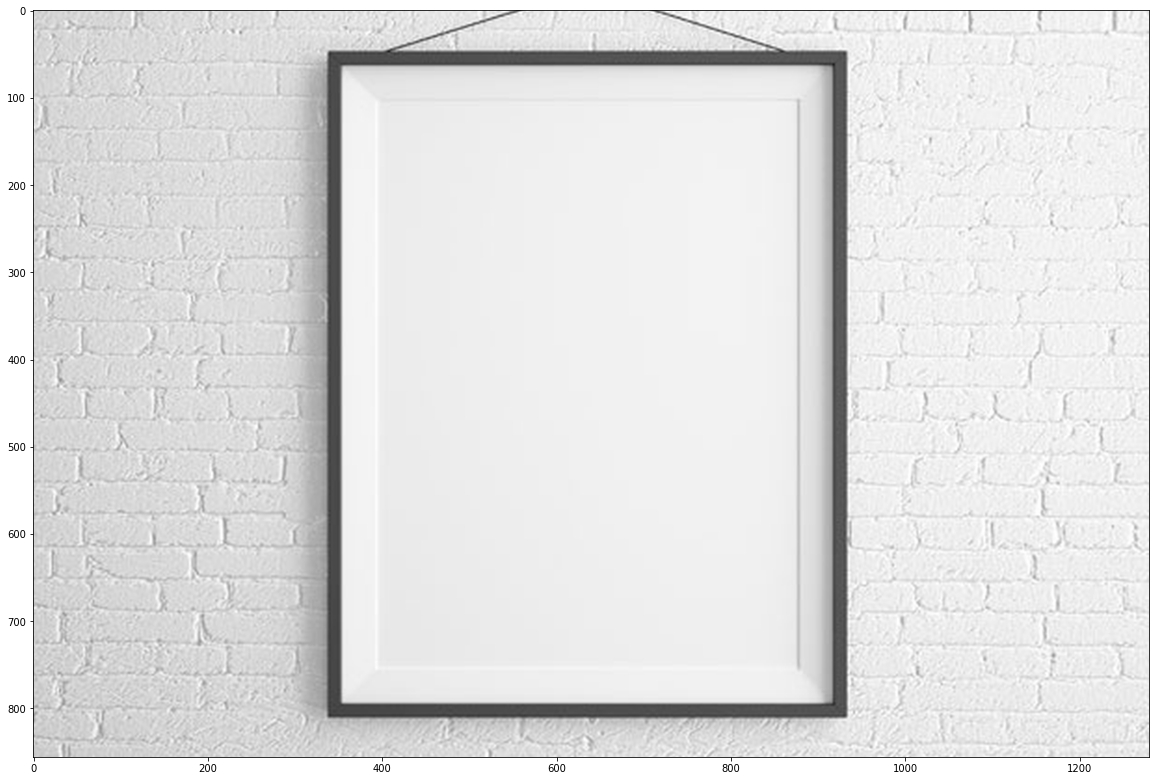

In [4]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "https://handymanwalthamstow.com/wp-content/uploads/2015/06/hanging-pictures-and-mirrors.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Pick an object detection module and apply on the downloaded image. Modules:
* **FasterRCNN+InceptionResNet V2**: high accuracy,
* **ssd+mobilenet V2**: small and fast.

In [5]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [6]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [7]:
def run_detector(detector, path, display = False):
    img = load_img(path)
    
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    
    begin = time.time()
      
    begin = time.time()
    result = detector(converted_img)
    end = time.time()
    print(end-begin)
    
    result = {key:value.numpy() for key,value in result.items()}

    detection_boxes = result["detection_boxes"]
    detection_class_entities = result["detection_class_entities"]
    detection_scores = result["detection_scores"]
    
    bool_arr = detection_class_entities == b'Picture frame'
    
    detection_scores=detection_scores[bool_arr]
    detection_boxes = detection_boxes[bool_arr]

    if np.any(bool_arr): 
        found = True
        index_max = max(range(len(detection_scores)), key=detection_scores.__getitem__)
   
        if display:
            image_with_boxes = draw_boxes(img.numpy(), detection_boxes[index_max], b'Picture frame',
                                     detection_scores[index_max])
            display_image(image_with_boxes)

        return detection_boxes[index_max],  detection_scores[index_max], found,(end-begin)
    else:
        return 0,0,False,(end-begin)

In [8]:
BASE_PATH = '/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/CustCNN'
DATA_PATH = os.path.sep.join([BASE_PATH, "Trimmeddata_bigger_test"])
VAL_IMAGES_PATH = os.path.sep.join([DATA_PATH, "test/images"])

VAL_IMAGES_PATH ='/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/CustCNN/Trimmeddata_bigger_test/typevoorbeelden'

ANNOT_TYPE = 'txt'
VAL_ANNOTS_PATH = os.path.sep.join([DATA_PATH, "test/_annotations.csv"])
print(VAL_ANNOTS_PATH)

/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/CustCNN/Trimmeddata_bigger_test/test/_annotations.csv


In [9]:
def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

In [10]:
#annotaties inladen

df=pd.read_csv(VAL_ANNOTS_PATH)
df = df.drop('class', axis=1)
df = df.drop('width', axis=1)
df = df.drop('height', axis=1)
df.head(5)

,filename,xmin,ymin,xmax,ymax
0,293e442438ebe3ae_jpg.rf.059af780b38cffec097999...,43,15,364,386
1,aa05dbe467400fbf_jpg.rf.136993704d04fdc6fb5c1b...,122,111,327,330
2,5c826816c70b0dec_jpg.rf.0629a7cbfa16af730e7f8b...,27,33,397,348
3,d32442c4e0c75b88_jpg.rf.073165b8c2896e53bc7843...,82,42,346,385
4,42ae41305ec3108f_jpg.rf.02a502233a61a91272a6bd...,75,3,349,369


In [11]:
i=0
ious = []
tijden = 0
from tensorflow.keras.preprocessing.image import load_img
#df = pandas.DataFrame(columns=["filename","confidence", "xmin", "ymax","xmax","ymin"])

for filename in os.listdir(VAL_IMAGES_PATH):
    i += 1
    #print("foto nr: ",i,"\n", filename)
    downloaded_image_path =  os.path.sep.join([VAL_IMAGES_PATH,filename])
    #print(downloaded_image_path)
    if filename != '.DS_Store':
        img = Image.open(downloaded_image_path)
        image = cv2.imread(downloaded_image_path)
        w, h = img.size
        
        
        row = df.loc[df['filename'] == filename]
        row = row.to_numpy()
        iou = 0
        if row.size != 0:
            print(row)
            startX = (row[0][1])
            startY = (row[0][2])
            endX= (row[0][3])
            endY= (row[0][4])
            
            box_2 = [[startX, startY], [endX, startY], [endX, endY], [startX, endY]]
           
        
        
        
        
        print("foto nr: ",i)
        box, score, found, tijd = run_detector(detector, downloaded_image_path, display = False)
        tijden+=tijd
        if found:
            xmin, ymax,xmax,ymin = box
            xmin = int(xmin * w)
            ymin = int(ymin * h)
            xmax = int(xmax * w)
            ymax = int(ymax * h)
        
        box_1 = [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
        iou = calculate_iou(box_1, box_2)
        iou = (round(iou, 2))
        ious.append(iou)
        cv2.rectangle(image, (int(startX), int(startY)), (int(endX), int(endY)),(0, 0, 255), 2)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax),(0, 255, 0), 2)
        
        cv2.rectangle(image, (xmin,ymax+20), (xmin+70, ymax), (0,255,0), -1)
        cv2.putText(img=image,text=('IOU: '+str(iou)), org=(xmin+5, ymax+15), fontFace=cv2.FONT_HERSHEY_DUPLEX , fontScale=0.4, color=(0, 0, 0),thickness=1) 
        
        path ='/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/Resultaten/TF/ssd+mobilenet/typeset/images'
        cv2.imwrite(os.path.join(path , filename), image)
        
        
        PRED_PATH = '/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/Resultaten/TF/ssd+mobilenet/typeset/annotations'    
        if ANNOT_TYPE == 'csv':
            annotation_path =  os.path.sep.join([PRED_PATH,(os.path.splitext(filename)[0]+'.txt')])
            df.loc[i] = [filename, score, xmin, ymax, xmax, ymin]
        elif ANNOT_TYPE == 'txt': 
            annotation_path =  os.path.sep.join([PRED_PATH,(os.path.splitext(filename)[0]+'.txt')])
            file = open(annotation_path, 'w')
            file.write( " ".join(['Picture-frame', str(score), str(xmin),  str(ymax), str(xmax), str(ymin)]))
print(tijden/i)
annotation_path =  os.path.sep.join([PRED_PATH,(os.path.splitext(filename)[0]+'.txt')])
file = open(annotation_path, 'w')
file.write( " ".join(['Picture-frame', str(score), str(xmin),  str(ymax), str(xmax), str(ymin)]))
if ANNOT_TYPE == 'csv':
    df.to_csv(os.path.join(path , 'inception_resnet_v2AnnotPred.csv'), index = False)

[['ec6549b0d52ee23f_jpg.rf.3131f0608a393a910ba824e49229857c.jpg' 28 92
  398 332]]
foto nr:  1
7.550135135650635
[['96941c79094a8a76_jpg.rf.1baf358f04dba1cdc63607f487fafe7d.jpg' 72 45
  394 363]]
foto nr:  2
0.12457108497619629
[['6770e9769455173a_jpg.rf.c3d0565bb59b4824fac671aeadc090f0.jpg' 39 10
  371 396]]
foto nr:  3
0.11406087875366211
[['cee363bb7afeca8c_jpg.rf.40c474b7c7263bcf69e0aac6690004d1.jpg' 90 70
  344 345]]
foto nr:  4
0.12179398536682129
[['32068589b0fd5de0_jpg.rf.9ca247a53d1c1224b17b1aa292561789.jpg' 43 49
  383 376]]
foto nr:  5
0.13231897354125977
[['aeb66f6549ffaf97_jpg.rf.9a6f02ca63fd9ef120dc4e04a918b974.jpg' 286 135
  380 314]]
foto nr:  7
0.12397313117980957
[['2238aa8c9adeb7e1_jpg.rf.5198911b0d7d4b60942378ae1fb66d06.jpg' 61 83
  282 355]]
foto nr:  8
0.1157979965209961
[['527ab7011f34969d_jpg.rf.1734602f0b43366b5f691b78a66c3973.jpg' 0 63 389
  342]]
foto nr:  9
0.12955498695373535
[['35e51ec6234af1c2_jpg.rf.957f6c1316db7a43e31c717d83ec346d.jpg' 69 39
  366 378]]

24


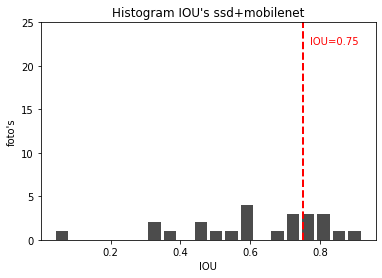

In [12]:
print(len(ious))
ious = np.array(ious)
plt.title("Histogram IOU's ssd+mobilenet")
plt.xlabel("IOU")
plt.ylabel("foto's")
plt.hist(x=ious, bins=20, color='#000000',
                            alpha=0.7, rwidth=0.8)
plt.axvline(0.75, color='r', linestyle='dashed', linewidth=2)
plt.text(0.77, 25*0.9, 'IOU=0.75',color='r')
plt.ylim(ymin=0, ymax = 25)
plt.show() 